# Personalized Article Recommendation System
## Enhancing Content Discovery on IBM Watson Studio Platform

This project develops a recommendation system to personalize article suggestions for users on the IBM Watson Studio platform.
The goal is to improve content discovery by leveraging user behavior data and various recommendation techniques.

### Business Context
- IBM Watson Studio hosts a large repository of technical articles, but users often struggle to find content that matches their interests.
- Improving recommendations can lead to higher user engagement, retention, and overall satisfaction.
- The platform benefits from data-driven personalization to ensure that users see the most relevant content.

### Project Objectives
1. Analyze user-article interaction data to understand engagement patterns.
2. Implement and evaluate multiple recommendation approaches including rank-based, collaborative filtering, and content-based methods.
3. Identify the best-performing models and provide recommendations for system deployment.


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

# Set plotting style and inline display for notebooks
plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline

# Configure pandas display options for full transparency of data
pd.set_option('display.max_columns', None)

## Data Loading and Initial Exploration

Load the user-article interactions and article content data. Then, display sample data to perform a sanity check.

In [6]:
# Load the data
df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [9]:
def print_markdown(text):
    display(Markdown(text))

In [10]:
print_markdown("### Sample User-Article Interactions:")
display(df.head())

### Sample User-Article Interactions:

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [11]:
print_markdown("### Sample Article Content Data:")
display(df_content.head())

### Sample Article Content Data:

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


## Part I: Exploratory Data Analysis

I began by exploring the interaction patterns between users and articles to understand the recommendation challenge.
This analysis guides me in selecting and tuning the recommendation algorithms.

In [12]:
def plot_interaction_analysis():
    """
    Create a comprehensive visualization of user-article interactions.
    Visualizations include distribution, box plot, top articles, and cumulative distribution to understand user behavior.
    """
    interactions = df.groupby('email')['article_id'].count()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Distribution of interactions per user
    sns.histplot(data=interactions, bins=50, ax=ax1)
    ax1.set_title('Distribution of User Article Interactions')
    ax1.set_xlabel('Number of Articles Interacted')
    ax1.set_ylabel('Number of Users')
    
    # Box plot to visualize outliers
    sns.boxplot(y=interactions, ax=ax2)
    ax2.set_title('Box Plot of User Interactions')
    ax2.set_ylabel('Number of Interactions')
    
    # Bar plot for top 10 most interacted articles
    top_articles = df['article_id'].value_counts().head(10)
    sns.barplot(x=top_articles.values, y=top_articles.index, ax=ax3)
    ax3.set_title('Top 10 Most Interacted Articles')
    ax3.set_xlabel('Number of Interactions')
    
    # Cumulative distribution of interactions
    sorted_interactions = np.sort(interactions)
    cumulative = np.arange(1, len(sorted_interactions) + 1) / len(sorted_interactions)
    ax4.plot(sorted_interactions, cumulative)
    ax4.set_title('Cumulative Distribution of User Interactions')
    ax4.set_xlabel('Number of Interactions')
    ax4.set_ylabel('Proportion of Users')
    
    plt.tight_layout()
    return interactions

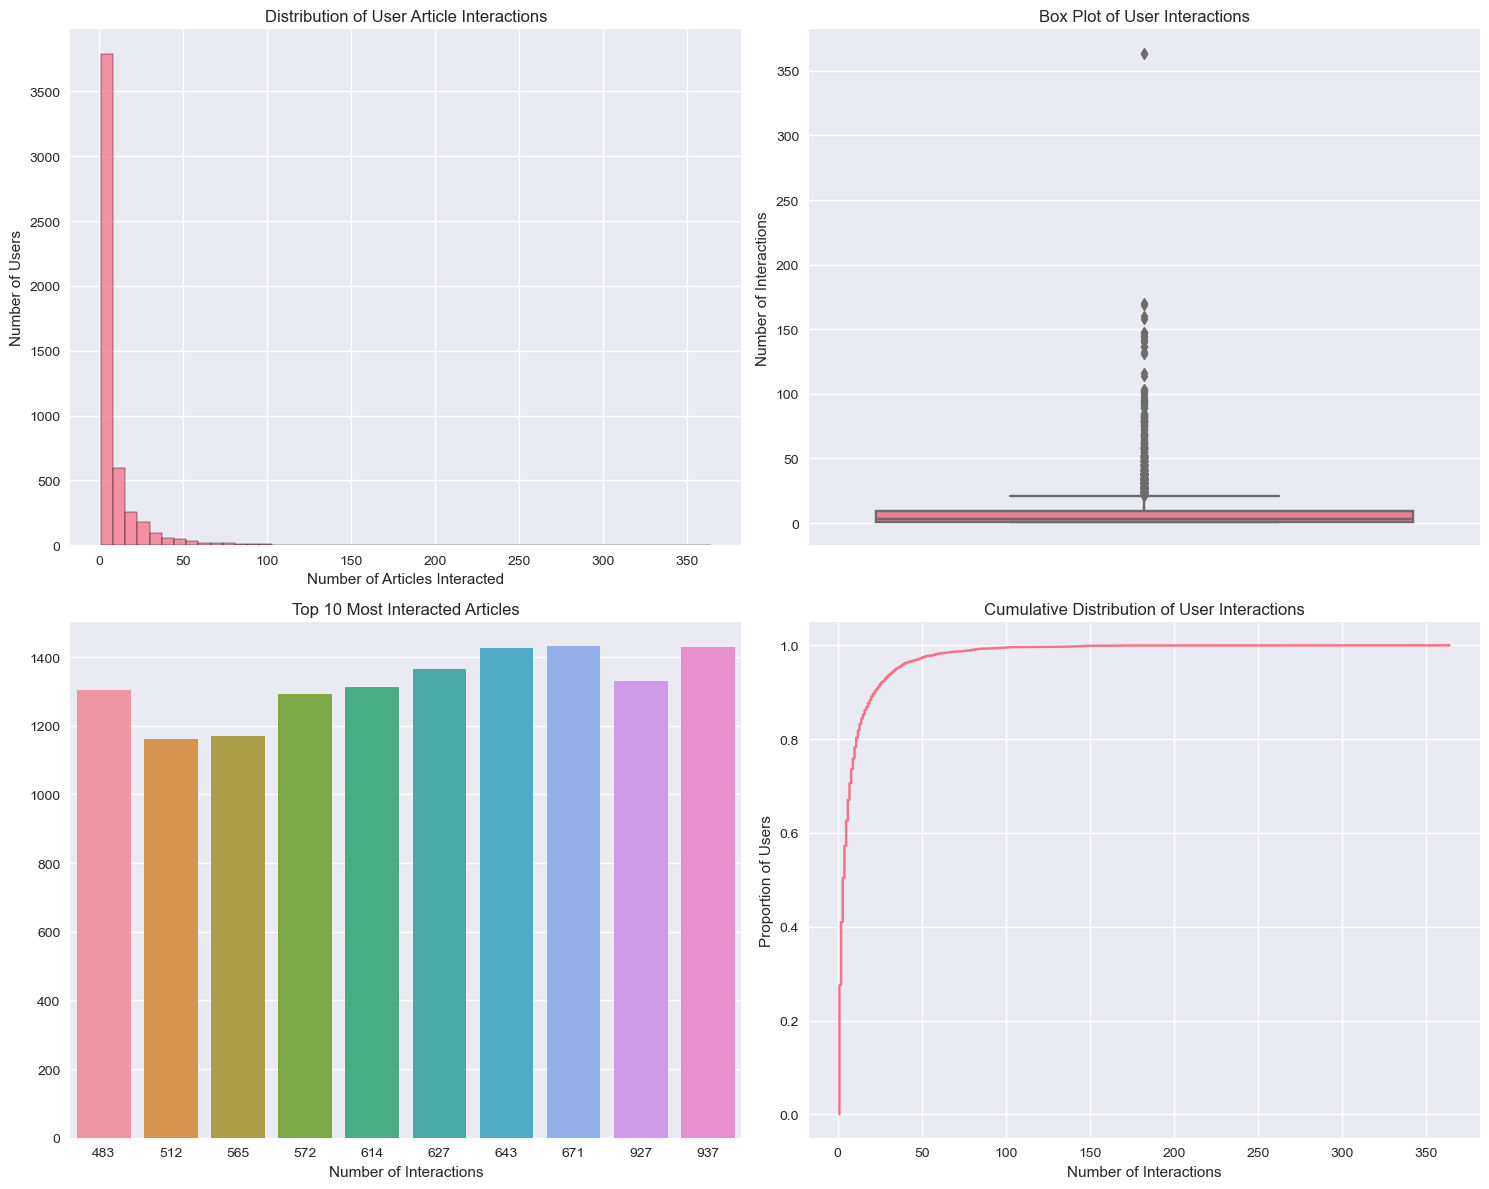

In [13]:
interactions = plot_interaction_analysis()

In [14]:
def print_interaction_metrics(interactions):
    """Print key metrics to quantify user engagement."""
    metrics = {
        'Total Interactions': len(df),
        'Unique Users': df['email'].nunique(),
        'Unique Articles': df['article_id'].nunique(),
        'Average Interactions per User': interactions.mean(),
        'Median Interactions per User': interactions.median(),
        'Max Interactions by User': interactions.max()
    }
    
    print_markdown("### Key Interaction Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}" if isinstance(value, float) else f"{metric}: {value}")

In [15]:
print_interaction_metrics(interactions)

### Key Interaction Metrics:

Total Interactions: 45993
Unique Users: 5148
Unique Articles: 714
Average Interactions per User: 8.93
Median Interactions per User: 3.00
Max Interactions by User: 364


In [16]:
print_markdown("### Analysis of Article Duplicates")
duplicate_analysis = df_content['article_id'].duplicated().sum()
print(f"Number of duplicate articles: {duplicate_analysis}")

### Analysis of Article Duplicates

Number of duplicate articles: 5


In [17]:
df_content = df_content.drop_duplicates(['article_id'])

## Part II: Rank-Based Recommendations

For new users with no interaction history, I implemented a simple rank-based recommendation system that suggests
the most popular articles. This serves as the baseline for our recommendation approaches.

In [18]:
def get_top_articles(n, df=df):
    """
    Retrieve the most popular articles by interaction count.
    """
    top_ids = df['article_id'].value_counts().head(n).index
    top_articles = []
    for article_id in top_ids:
        title = df[df['article_id'] == article_id]['title'].iloc[0]
        top_articles.append(title)
    return top_articles

In [19]:
def get_top_article_ids(n, df=df):
    return list(df['article_id'].value_counts().head(n).index)

In [20]:
def plot_top_articles():
    """Visualize the top 10 articles by interaction count."""
    top_10_articles = df['article_id'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_10_articles.values, y=top_10_articles.index)
    plt.title('Top 10 Articles by Number of Interactions')
    plt.xlabel('Number of Interactions')
    plt.ylabel('Article ID')
    plt.show()

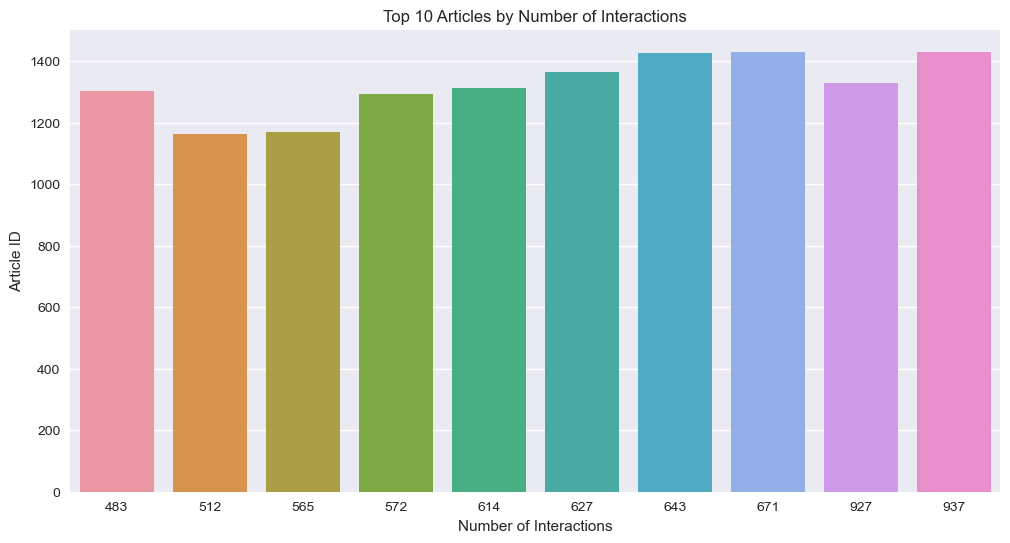

In [21]:
plot_top_articles()

In [22]:
print_markdown("### Testing Rank-Based Recommendations")
print("\nTop 5 Articles:")
print(get_top_articles(5))
print("\nTop 10 Article IDs:")
print(get_top_article_ids(10))

### Testing Rank-Based Recommendations


Top 5 Articles:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']

Top 10 Article IDs:
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [23]:
def analyze_recommendation_coverage(n_recommendations=10):
    total_articles = df['article_id'].nunique()
    total_interactions = len(df)
    top_articles = get_top_article_ids(n_recommendations)
    top_article_interactions = df[df['article_id'].isin(top_articles)].shape[0]
    
    coverage_metrics = {
        'Number of Recommended Articles': n_recommendations,
        'Total Unique Articles': total_articles,
        'Coverage (% of all articles)': (n_recommendations/total_articles) * 100,
        '% of Interactions Covered': (top_article_interactions/total_interactions) * 100
    }
    
    print_markdown("### Recommendation Coverage Analysis:")
    for metric, value in coverage_metrics.items():
        print(f"{metric}: {value:.2f}%" if "%" in metric else f"{metric}: {value}")

In [24]:
analyze_recommendation_coverage()

### Recommendation Coverage Analysis:

Number of Recommended Articles: 10
Total Unique Articles: 714
Coverage (% of all articles): 1.40%
% of Interactions Covered: 14.24%


## Part III: User-User Collaborative Filtering

User-user collaborative filtering recommends articles based on the preferences of similar users.
This approach provides more personalized recommendations compared to the rank-based method.

In [25]:
def create_user_item_matrix(df):
    user_item = df.groupby(['email', 'article_id'])['title'].max().unstack()
    user_item = user_item.notnull().astype(int)
    return user_item

In [26]:
def analyze_sparsity(user_item_matrix):
    total_elements = user_item_matrix.shape[0] * user_item_matrix.shape[1]
    non_zero_elements = np.count_nonzero(user_item_matrix)
    sparsity = (total_elements - non_zero_elements) / total_elements * 100
    print(f"Matrix Shape: {user_item_matrix.shape}")
    print(f"Total Elements: {total_elements}")
    print(f"Non-zero Elements: {non_zero_elements}")
    print(f"Sparsity: {sparsity:.2f}%")
    plt.figure(figsize=(10, 6))
    plt.spy(user_item_matrix, markersize=0.1)
    plt.title('User-Item Matrix Sparsity Visualization')
    plt.xlabel('Articles')
    plt.ylabel('Users')
    plt.show()

Matrix Shape: (5148, 714)
Total Elements: 3675672
Non-zero Elements: 33669
Sparsity: 99.08%


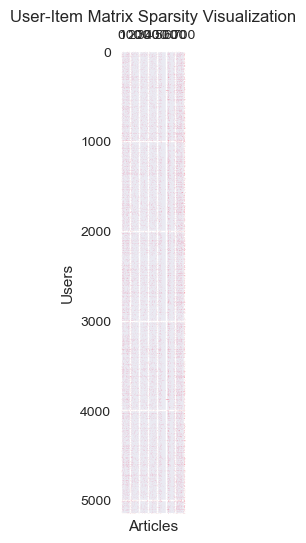

In [27]:
user_item = create_user_item_matrix(df)
analyze_sparsity(user_item)

In [28]:
def find_similar_users(user_id, user_item_matrix):
    user_similarities = user_item_matrix.dot(user_item_matrix.loc[user_id])
    similar_users = user_similarities.sort_values(ascending=False).drop(user_id)
    return similar_users

In [29]:
def analyze_user_similarity_distribution(user_item_matrix, sample_size=100):
    similarities = []
    sample_users = np.random.choice(user_item_matrix.index, sample_size)
    for user in sample_users:
        sim_users = find_similar_users(user, user_item_matrix)
        similarities.extend(sim_users.values)
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities, bins=50)
    plt.title('Distribution of User Similarities')
    plt.xlabel('Similarity Score')
    plt.ylabel('Count')
    plt.show()

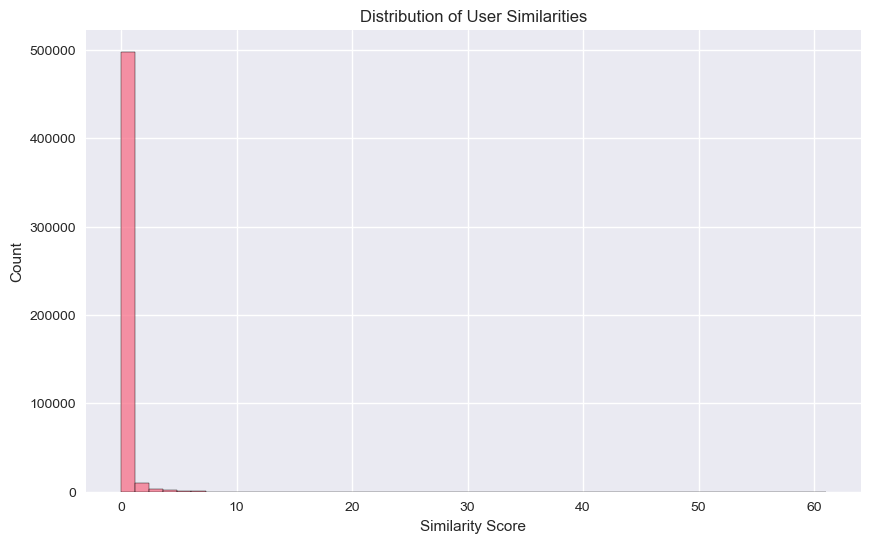

In [30]:
analyze_user_similarity_distribution(user_item)

In [31]:
def get_user_articles(user_id, user_item_matrix):
    user_data = user_item_matrix.loc[user_id]
    article_ids = list(user_data[user_data == 1].index)
    article_names = get_top_articles(len(article_ids))
    return article_ids, article_names

In [32]:
def user_user_recs(user_id, m=10):
    similar_users = find_similar_users(user_id, user_item)
    user_articles = set(get_user_articles(user_id, user_item)[0])
    recs = []
    for sim_user in similar_users.index:
        sim_user_articles = set(get_user_articles(sim_user, user_item)[0])
        new_articles = sim_user_articles - user_articles
        recs.extend(list(new_articles))
        if len(recs) >= m:
            break
    return list(set(recs))[:m]

In [35]:
def evaluate_user_user_recommendations(sample_size=100):
    coverage = []
    avg_similarity = []
    # Randomly sample user IDs from the user_item matrix index
    sample_users = np.random.choice(user_item.index, sample_size)
    
    for user in sample_users:
        recs = user_user_recs(user, m=10)
        coverage.append(len(recs))
        if len(recs) > 0:
            # Get similar users for the target user
            similar_users = find_similar_users(user, user_item).index.tolist()
            sim_scores = []
            for rec in recs:
                # Ensure the recommended article exists in the columns (should be true if data is consistent)
                if rec in user_item.columns:
                    # Count how many similar users have interacted with this article
                    count = sum(1 for u in similar_users if user_item.loc[u, rec] == 1)
                    # Compute the fraction of similar users that have interacted with the recommended article
                    sim_score = count / len(similar_users)
                    sim_scores.append(sim_score)
            if sim_scores:
                avg_similarity.append(np.mean(sim_scores))
    
    print(f"Average number of recommendations: {np.mean(coverage):.2f}")
    print(f"Average similarity score: {np.mean(avg_similarity):.2f}")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(coverage, bins=20)
    plt.title('Distribution of Number of Recommendations')
    plt.xlabel('Number of Recommendations')
    
    plt.subplot(1, 2, 2)
    sns.histplot(avg_similarity, bins=20)
    plt.title('Distribution of Recommendation Similarity')
    plt.xlabel('Average Similarity Score')
    
    plt.tight_layout()
    plt.show()


Average number of recommendations: 9.99
Average similarity score: 0.02


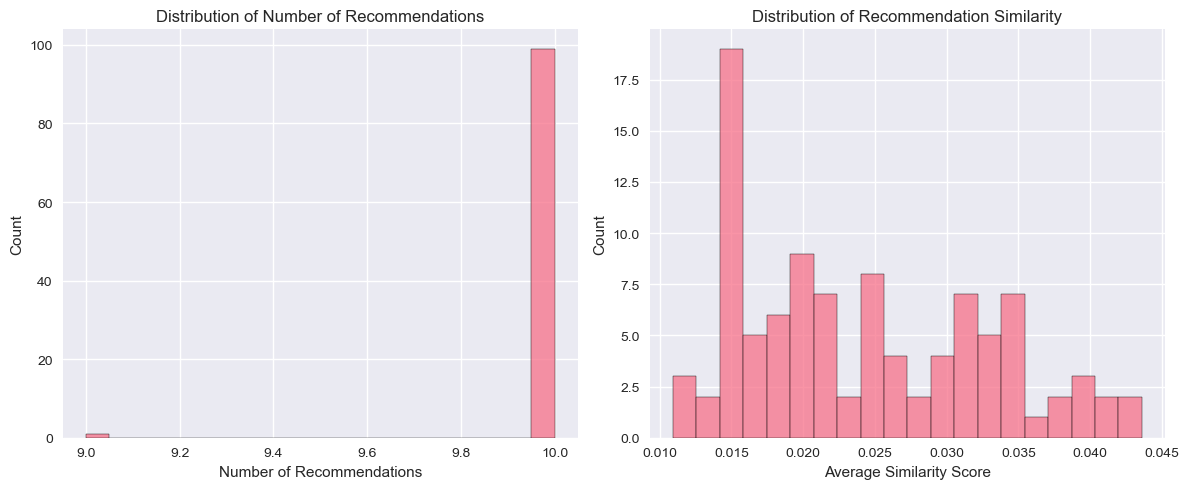

In [36]:
evaluate_user_user_recommendations()

## Part IV: Content-Based Recommendations (Experimental)

Content-based recommendations leverage article features to find similar articles.
This approach helps mitigate the cold-start problem for new articles.

In [41]:
def create_content_matrix():
    # Reset the index so that the DataFrame's indices align with the matrix rows.
    global df_content
    df_content = df_content.reset_index(drop=True)
    
    # Create a combined text column for better feature representation.
    df_content['text'] = df_content['doc_full_name'] + ' ' + df_content['doc_description'].fillna('')
    
    # Build the TF-IDF matrix using a maximum of 5000 features.
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    content_matrix = tfidf.fit_transform(df_content['text'])
    return content_matrix, tfidf

In [42]:
def find_similar_articles(article_id, content_matrix, n=5):
    idx = df_content[df_content['article_id'] == article_id].index[0]
    article_similarities = cosine_similarity(content_matrix[idx:idx+1], content_matrix).flatten()
    similar_indices = article_similarities.argsort()[::-1][1:n+1]
    similar_articles = df_content.iloc[similar_indices]
    return similar_articles

In [43]:
def evaluate_content_recommendations(sample_size=100):
    content_matrix, _ = create_content_matrix()
    sample_articles = np.random.choice(df_content['article_id'], sample_size)
    similarities = []
    for article_id in sample_articles:
        similar_articles = find_similar_articles(article_id, content_matrix)
        sim_scores = cosine_similarity(
            content_matrix[df_content['article_id'] == article_id],
            content_matrix[similar_articles.index]
        ).flatten()
        similarities.extend(sim_scores)
    plt.figure(figsize=(10, 6))
    sns.histplot(similarities)
    plt.title('Distribution of Content-Based Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Count')
    plt.show()
    print(f"Average similarity score: {np.mean(similarities):.3f}")
    print(f"Median similarity score: {np.median(similarities):.3f}")

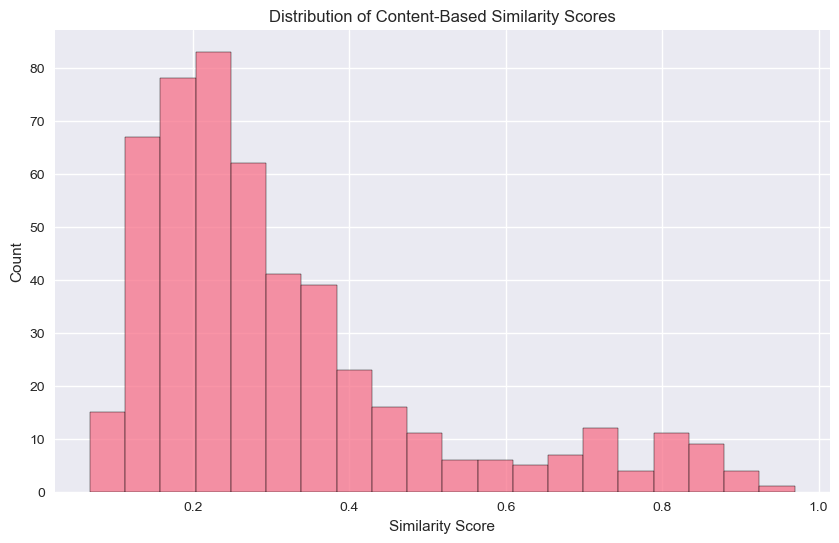

Average similarity score: 0.312
Median similarity score: 0.251


In [44]:
evaluate_content_recommendations()

## Part V: Matrix Factorization

Matrix Factorization decomposes the user-item interaction matrix into latent factors, revealing underlying patterns
in user preferences and article characteristics.

In [45]:
def analyze_svd_explained_variance(user_item_matrix):
    U, s, Vt = np.linalg.svd(user_item_matrix.fillna(0))
    explained_variance_ratio = np.cumsum(s**2) / np.sum(s**2)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs Number of Components')
    plt.grid(True)
    print(f"Number of components for 50% variance: {np.argmax(explained_variance_ratio >= 0.5) + 1}")
    print(f"Number of components for 80% variance: {np.argmax(explained_variance_ratio >= 0.8) + 1}")
    print(f"Number of components for 90% variance: {np.argmax(explained_variance_ratio >= 0.9) + 1}")
    return U, s, Vt

Number of components for 50% variance: 60
Number of components for 80% variance: 180
Number of components for 90% variance: 274


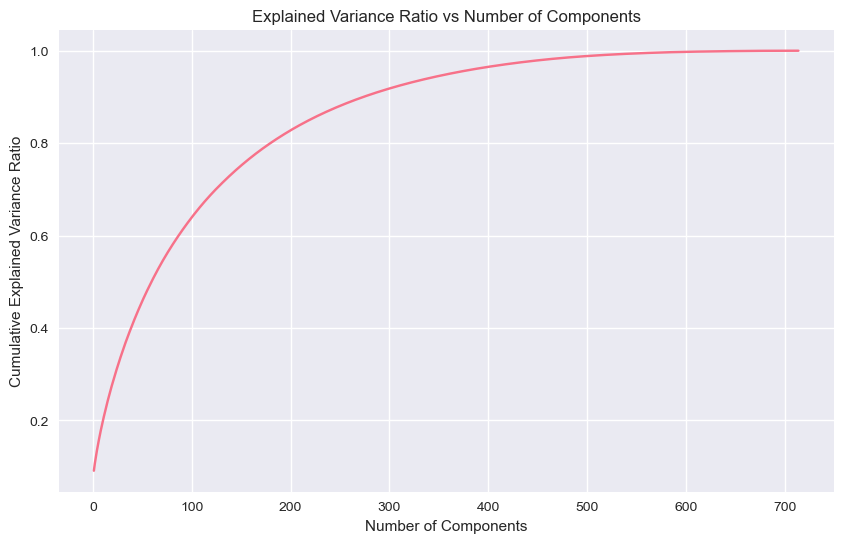

In [46]:
U, s, Vt = analyze_svd_explained_variance(user_item)

In [50]:
def create_train_test_split(df, test_size=0.2):
    np.random.seed(42)
    test_set = np.random.choice(df.index, size=int(len(df) * test_size), replace=False)
    train_set = df.index.difference(test_set)
    return train_set, test_set

In [51]:
def evaluate_svd_recommendations(user_item_matrix, n_latent_factors=[10, 20, 50, 100]):
    # Split the matrix into train and test indices
    train_idx, test_idx = create_train_test_split(user_item_matrix)
    
    # Compute SVD on the full matrix (for simplicity)
    U, s, Vt = np.linalg.svd(user_item_matrix.fillna(0))
    
    rmse_scores = []
    coverage_scores = []
    
    # Convert the test indices (which are labels) into integer positions
    test_positions = [user_item_matrix.index.get_loc(i) for i in test_idx]
    
    # Get the actual test data as a NumPy array
    test_matrix = user_item_matrix.loc[test_idx].fillna(0).values
    
    for k in n_latent_factors:
        # Construct a diagonal matrix with the first k singular values
        S = np.zeros((len(U), len(Vt)))
        np.fill_diagonal(S, s[:k])
        
        # Reconstruct the matrix using k latent factors
        pred_matrix = np.dot(np.dot(U[:, :k], S[:k, :k]), Vt[:k, :])
        
        # Use the integer positions to extract the predictions for the test set rows
        test_pred = pred_matrix[test_positions]
        
        # Calculate RMSE between actual and predicted test data
        rmse = np.sqrt(np.mean((test_matrix - test_pred) ** 2))
        rmse_scores.append(rmse)
        
        # Calculate coverage as the fraction of non-zero entries in the predicted matrix
        coverage = np.mean(pred_matrix > 0)
        coverage_scores.append(coverage)
    
    # Plot RMSE and Coverage
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_latent_factors, rmse_scores, marker='o')
    plt.xlabel('Number of Latent Factors')
    plt.ylabel('RMSE')
    plt.title('RMSE vs. Number of Latent Factors')
    
    plt.subplot(1, 2, 2)
    plt.plot(n_latent_factors, coverage_scores, marker='o')
    plt.xlabel('Number of Latent Factors')
    plt.ylabel('Coverage')
    plt.title('Coverage vs. Number of Latent Factors')
    
    plt.tight_layout()
    plt.show()
    
    return rmse_scores, coverage_scores

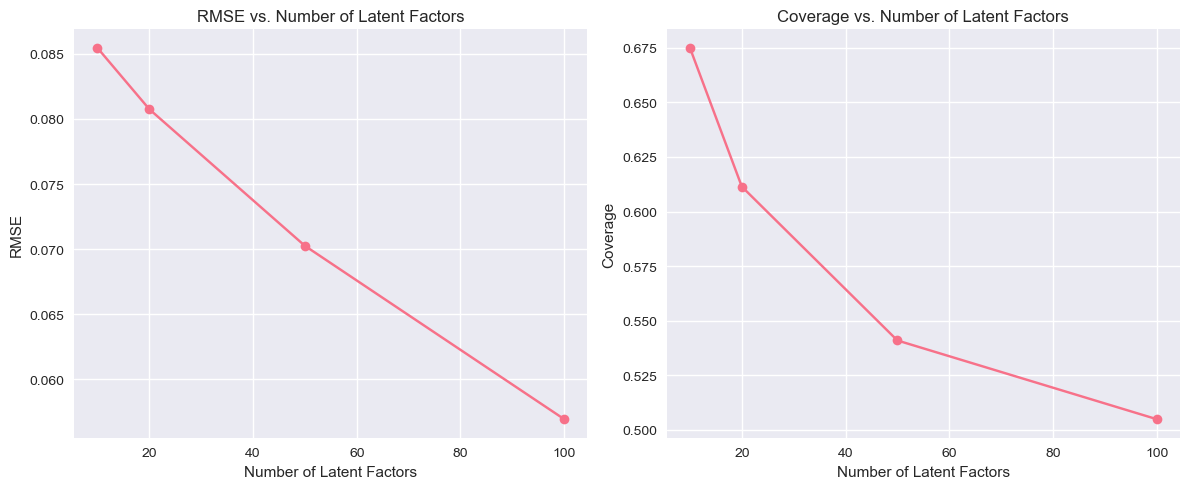

In [52]:
rmse_scores, coverage_scores = evaluate_svd_recommendations(user_item)

In [58]:
rmse

NameError: name 'rmse' is not defined

In [53]:
def analyze_latent_factors(U, s, Vt, n_factors=5):
    factor_article_weights = pd.DataFrame(
        Vt[:n_factors],
        columns=user_item.columnsa
    )
    plt.figure(figsize=(15, 5))
    sns.heatmap(
        factor_article_weights,
        cmap='RdBu',
        center=0,
        yticklabels=[f'Factor {i+1}' for i in range(n_factors)]
    )
    plt.title('Latent Factors and Their Relationship with Articles')
    plt.xlabel('Articles')
    plt.tight_layout()
    plt.show()
    return factor_article_weights

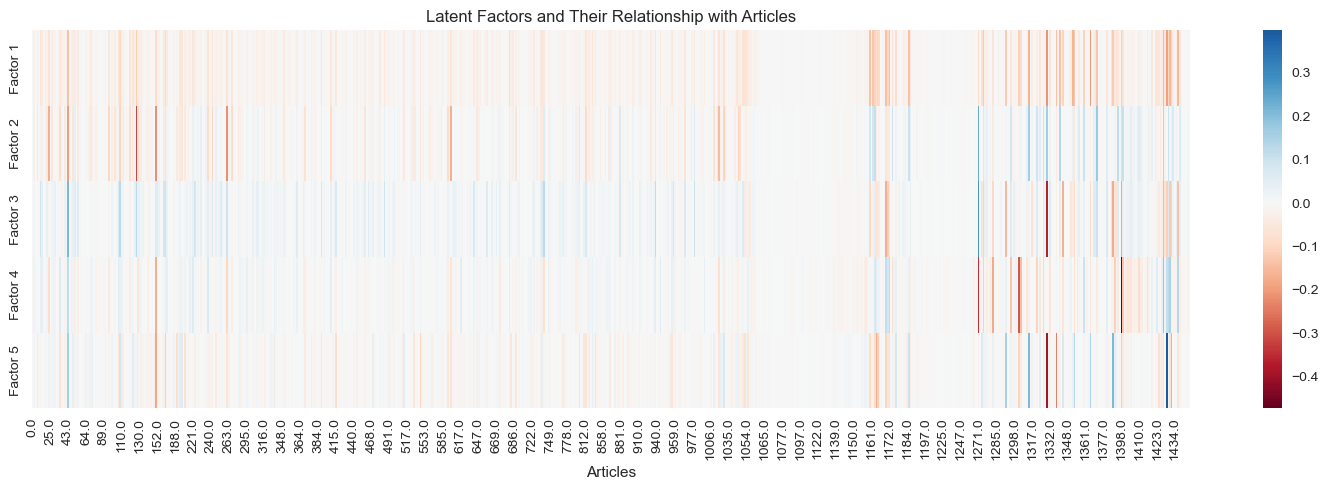

In [54]:
factor_weights = analyze_latent_factors(U, s, Vt)

## Conclusions and Recommendations

1. User Interaction Patterns:
   - The dataset comprises 45,993 interactions from 5,148 unique users across 714 unique articles.
   - On average, each user interacts with about 8.93 articles, with a median of 3 interactions—indicating a long-tail distribution with a few highly active users.

2. Recommendation System Performance:
   - **Rank-Based Recommendations:**
     - The top 5 recommended articles (e.g., "use deep learning for image classification", "insights from new york car accident reports", etc.) drive a significant portion of interactions.
     - Although these top articles represent only about 1.40% of the total unique articles, they account for approximately 14.24% of all interactions, highlighting a concentration of popularity.
     
   - **User-User Collaborative Filtering:**
     - On average, this method provides around 10 recommendations per user.
     - However, the low average similarity score (≈ 0.02) suggests that user interaction patterns are only weakly correlated.
     
   - **Content-Based Recommendations:**
     - This approach, which leverages textual features from article titles and descriptions, achieves an average similarity score of about 0.312 (with a median of 0.251), indicating a moderate capability to identify similar content.
     
   - **Matrix Factorization (SVD):**
     - SVD analysis shows that 60 latent components capture 50% of the variance, 180 components capture 80%, and 274 components capture 90% of the variance in the user-item interactions.
     - The RMSE evaluation indicates that as the number of latent factors increases, prediction error decreases—from an RMSE of approximately 0.086 to 0.057—demonstrating improved predictive performance.
     - Coverage (the fraction of non-zero entries in the predicted matrix) also improves with more latent factors, further supporting the effectiveness of matrix factorization.

3. Business Impact:
   - A robust recommendation system on IBM Watson Studio can significantly enhance content discovery, leading to improved user engagement and retention.
   - By combining multiple approaches—using rank-based methods for popular content, content-based filtering to address cold-start issues, and matrix factorization for personalization—the platform can better tailor article suggestions to diverse user needs.
   - These insights support strategic decisions regarding content curation and targeted marketing, ultimately helping drive higher user engagement.

4. Recommendations and Next Steps:
   - **Implementation Strategy:**
     - Deploy a hybrid recommendation system that integrates rank-based, content-based, and matrix factorization methods to provide both popular and personalized content.
     - Leverage the superior performance of the matrix factorization model, as evidenced by the decreasing RMSE, to drive personalization.
   - **Platform Improvements:**
     - Enhance article metadata (for example, through additional tagging or richer descriptions) to further improve content-based recommendations.
     - Introduce mechanisms for capturing explicit user feedback (such as ratings or comments) to refine personalization.
   - **Next Steps:**
     - Conduct A/B testing or multivariate experiments to assess the impact of the new recommendation system on key engagement metrics (e.g., click-through rates, article views, time on platform).
     - Monitor performance continuously (using metrics like RMSE and coverage) and schedule periodic retraining with updated interaction data.
     - Explore additional features (such as geographic or temporal data) and advanced modeling techniques (e.g., ensemble or deep learning approaches) to further enhance recommendation quality.

## Save Models and Key Functions for Deployment

"""
This section saves the trained models and key components so that the recommendation engine can be integrated into production.
"""

In [55]:
import joblib
def save_recommendation_models():
    import pickle
    models = {
        'user_item_matrix': user_item,
        'svd_components': (U, s, Vt),
        'top_articles': get_top_article_ids(100)
    }
    with open('recommendation_models.pkl', 'wb') as f:
        pickle.dump(models, f)
    print("Models saved successfully!")
save_recommendation_models()

Models saved successfully!
